# Predict on only zip code

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

# Stats packages
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("no_nans.csv")
df.head()

,time,00100,00260,00360,00500,00520,00730,00820,01280,01300,...,33200,33560,33580,33710,33820,33850,33960,36200,37120,40520
0,2010Q1 Price per square meter (EUR/m2),5168.0,4873.0,2756.0,4058.0,3317.0,3006.0,2652.0,2098.0,2616.0,...,2827.0,1951.0,2152.0,1760.0,1859.0,1227.0,1897.0,1747.0,1613.0,1968.0
1,2010Q2 Price per square meter (EUR/m2),5219.0,5086.0,3051.0,4111.0,3706.0,3070.0,2561.0,2045.0,2688.0,...,3094.0,1816.0,2039.0,1803.0,1970.0,1254.0,2026.0,1659.0,1542.0,2110.0
2,2010Q3 Price per square meter (EUR/m2),5181.0,4939.0,2889.0,4247.0,3672.0,2944.0,2632.0,2210.0,2814.0,...,3001.0,2081.0,1978.0,1851.0,1916.0,1338.0,1700.0,1851.0,1582.0,2096.0
3,2010Q4 Price per square meter (EUR/m2),5269.0,4906.0,3037.0,4226.0,3681.0,3046.0,2580.0,2359.0,2727.0,...,2990.0,1963.0,2102.0,1740.0,1980.0,1287.0,1881.0,1715.0,1745.0,2180.0
4,2011Q1 Price per square meter (EUR/m2),5632.0,5272.0,3188.0,4342.0,3654.0,3061.0,2793.0,2165.0,2734.0,...,3122.0,2142.0,2181.0,1838.0,1851.0,1398.0,1847.0,1836.0,1660.0,2116.0


In [3]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df.time = df.time.apply(lambda row: quarter_to_datetime(row))


In [4]:
df.set_index("time",inplace=True)
df.head()

,00100,00260,00360,00500,00520,00730,00820,01280,01300,01450,...,33200,33560,33580,33710,33820,33850,33960,36200,37120,40520
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,5168.0,4873.0,2756.0,4058.0,3317.0,3006.0,2652.0,2098.0,2616.0,1809.0,...,2827.0,1951.0,2152.0,1760.0,1859.0,1227.0,1897.0,1747.0,1613.0,1968.0
2010-04-01,5219.0,5086.0,3051.0,4111.0,3706.0,3070.0,2561.0,2045.0,2688.0,2063.0,...,3094.0,1816.0,2039.0,1803.0,1970.0,1254.0,2026.0,1659.0,1542.0,2110.0
2010-07-01,5181.0,4939.0,2889.0,4247.0,3672.0,2944.0,2632.0,2210.0,2814.0,2080.0,...,3001.0,2081.0,1978.0,1851.0,1916.0,1338.0,1700.0,1851.0,1582.0,2096.0
2010-10-01,5269.0,4906.0,3037.0,4226.0,3681.0,3046.0,2580.0,2359.0,2727.0,2052.0,...,2990.0,1963.0,2102.0,1740.0,1980.0,1287.0,1881.0,1715.0,1745.0,2180.0
2011-01-01,5632.0,5272.0,3188.0,4342.0,3654.0,3061.0,2793.0,2165.0,2734.0,2200.0,...,3122.0,2142.0,2181.0,1838.0,1851.0,1398.0,1847.0,1836.0,1660.0,2116.0


## Test stationarity

In [5]:
df_exp = df.iloc[:,1]
df_exp = diff(df_exp)


In [6]:
def test_stationarity(timeseries, maxlag=4*2):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

test_stationarity(df_exp)

Results of Dickey-Fuller Test:
Test Statistic                 -5.892
p-value                         0.000
#Lags Used                      2.000
Number of Observations Used    42.000
Critical Value (1%)            -3.597
Critical Value (5%)            -2.933
Critical Value (10%)           -2.605
dtype: float64


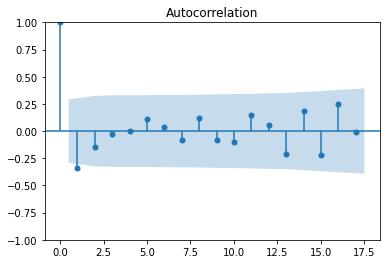

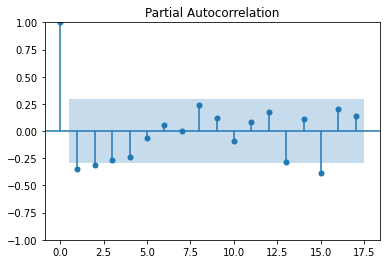

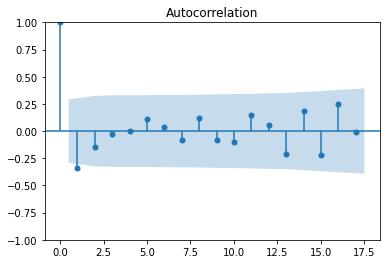

In [7]:

plot_pacf(df_exp)
plot_acf(df_exp)

In [8]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

test_stationarity(df_exp)

Results of Dickey-Fuller Test:


ValueError: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors

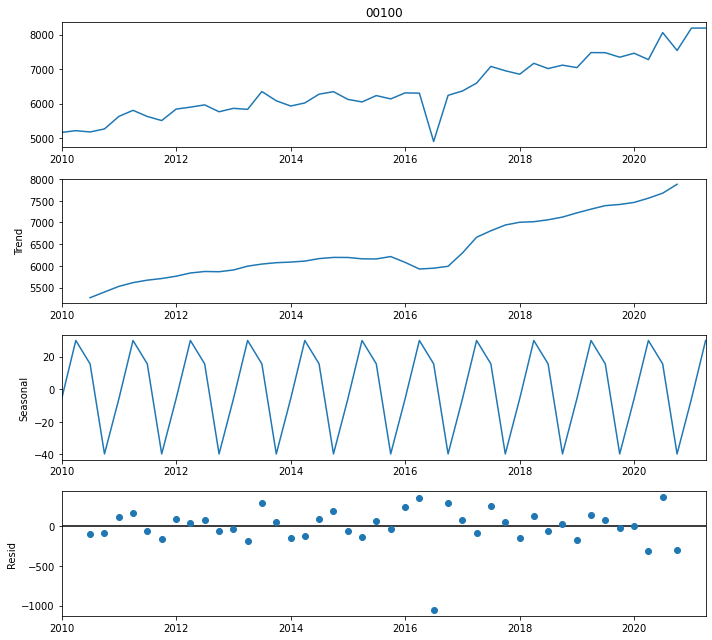

In [ ]:
decompose = seasonal_decompose(df.iloc[:,0], model="additive")
plt.rcParams.update({'figure.figsize':(10,9)})
f = decompose.plot()

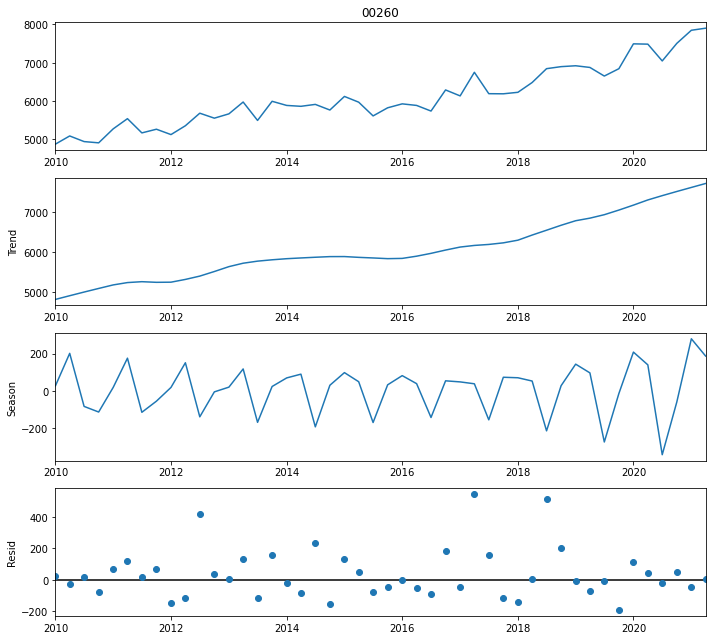

In [9]:
plt.rcParams.update({'figure.figsize':(10,9)})
stl = STL(df.iloc[:,1],robust=True)
res = stl.fit()
fig = res.plot()

<AxesSubplot:xlabel='time'>

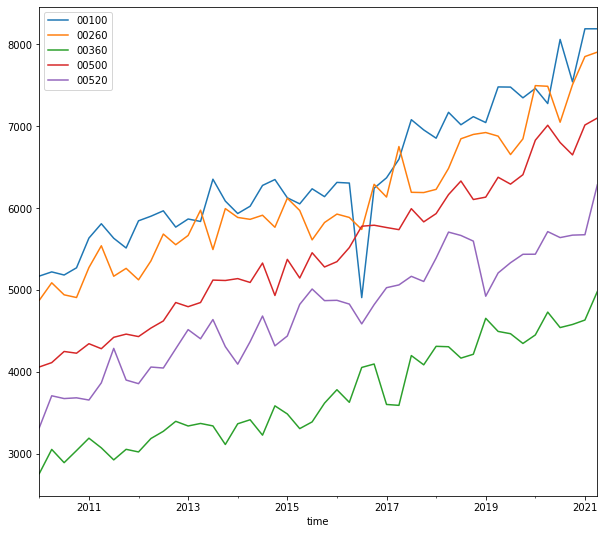

In [10]:
df.iloc[:,:5].plot()

### Let's start prediction

In [11]:
# mod = VARMAX(df,order=(1,1),trend='t')
# res = mod.fit(maxiter=200)
# print(res.summary())

In [12]:
def sarimax_params_search(multivar_ts, p=2, d=1, q=2, P=2, D=1, Q=2, s=4):
    """
    Keyword arguments:
    multivar_ts -- pandas dataframe of shape (n,m) where n is the number of
    time steps and n is the number of variables for prediction.
    """
    best_params = pd.Series(index=multivar_ts.columns)
    
    # set parameter range
    p,d,q = range(0,p+1),[d],range(0,q+1)
    P,D,Q,s = range(0,P+1),[D],range(0,Q+1),[s]
    
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))
    all_param = list(itertools.product(pdq,seasonal_pdq))
    
    for column in multivar_ts:
        best_param, best_aic = all_param[0], np.inf
        for param in all_param:
            try:
                mod = SARIMAX(multivar_ts[column],
                            order=param[0],
                            seasonal_order=param[1]
                            )
                res = mod.fit(disp=0,)
                if res.aic < best_aic:
                    best_param, best_aic = param, res.aic
            except Exception as e:
                print(e)
                continue
            
        best_params[column] = best_param
        print(f'The best model for {column} is: SARIMAX{best_param[0]}x{best_param[1]} \
            - AIC:{round(best_aic,2)}')
            
    return best_params

In [13]:
postal_params_all = sarimax_params_search(df)
postal_params_all

The best model for 00100 is: SARIMAX(0, 1, 1)x(0, 1, 1, 4)             - AIC:613.2
The best model for 00260 is: SARIMAX(0, 1, 1)x(0, 1, 1, 4)             - AIC:582.2
The best model for 00360 is: SARIMAX(2, 1, 1)x(0, 1, 1, 4)             - AIC:561.3
The best model for 00500 is: SARIMAX(0, 1, 1)x(0, 1, 1, 4)             - AIC:537.16
The best model for 00520 is: SARIMAX(2, 1, 2)x(0, 1, 1, 4)             - AIC:569.46
The best model for 00730 is: SARIMAX(0, 1, 2)x(0, 1, 1, 4)             - AIC:578.0
The best model for 00820 is: SARIMAX(2, 1, 0)x(0, 1, 1, 4)             - AIC:542.31
The best model for 01280 is: SARIMAX(0, 1, 1)x(2, 1, 0, 4)             - AIC:523.19
The best model for 01300 is: SARIMAX(0, 1, 1)x(2, 1, 0, 4)             - AIC:534.05
The best model for 01450 is: SARIMAX(1, 1, 0)x(0, 1, 2, 4)             - AIC:537.35
The best model for 02200 is: SARIMAX(2, 1, 0)x(0, 1, 1, 4)             - AIC:575.6
The best model for 02210 is: SARIMAX(0, 1, 1)x(0, 1, 1, 4)             - AIC:512.

00100    ((0, 1, 1), (0, 1, 1, 4))
00260    ((0, 1, 1), (0, 1, 1, 4))
00360    ((2, 1, 1), (0, 1, 1, 4))
00500    ((0, 1, 1), (0, 1, 1, 4))
00520    ((2, 1, 2), (0, 1, 1, 4))
00730    ((0, 1, 2), (0, 1, 1, 4))
00820    ((2, 1, 0), (0, 1, 1, 4))
01280    ((0, 1, 1), (2, 1, 0, 4))
01300    ((0, 1, 1), (2, 1, 0, 4))
01450    ((1, 1, 0), (0, 1, 2, 4))
02200    ((2, 1, 0), (0, 1, 1, 4))
02210    ((0, 1, 1), (0, 1, 1, 4))
02320    ((1, 1, 2), (0, 1, 1, 4))
02400    ((0, 1, 1), (1, 1, 2, 4))
02760    ((1, 1, 1), (0, 1, 1, 4))
03100    ((0, 1, 2), (0, 1, 1, 4))
04410    ((0, 1, 1), (0, 1, 1, 4))
06100    ((0, 1, 2), (2, 1, 0, 4))
20100    ((1, 1, 2), (2, 1, 0, 4))
20320    ((0, 1, 1), (0, 1, 2, 4))
20540    ((2, 1, 0), (1, 1, 0, 4))
20780    ((0, 1, 1), (0, 1, 1, 4))
20810    ((0, 1, 1), (2, 1, 1, 4))
21200    ((1, 1, 0), (0, 1, 1, 4))
23500    ((2, 1, 0), (2, 1, 2, 4))
24100    ((0, 1, 1), (0, 1, 2, 4))
26100    ((0, 1, 2), (0, 1, 1, 4))
33200    ((2, 1, 0), (0, 1, 1, 4))
33560    ((2, 1, 0),

In [38]:
postal_params = sarimax_params_search(df)
postal_params

The best model for 00100 is: SARIMAX(0, 1, 1)x(0, 1, 1, 4)             - AIC:613.2
The best model for 00260 is: SARIMAX(0, 1, 1)x(0, 1, 1, 4)             - AIC:582.2
The best model for 00360 is: SARIMAX(2, 1, 1)x(0, 1, 1, 4)             - AIC:561.3
The best model for 00500 is: SARIMAX(0, 1, 1)x(0, 1, 1, 4)             - AIC:537.16
The best model for 00520 is: SARIMAX(2, 1, 2)x(0, 1, 1, 4)             - AIC:569.46


00100    ((0, 1, 1), (0, 1, 1, 4))
00260    ((0, 1, 1), (0, 1, 1, 4))
00360    ((2, 1, 1), (0, 1, 1, 4))
00500    ((0, 1, 1), (0, 1, 1, 4))
00520    ((2, 1, 2), (0, 1, 1, 4))
dtype: object

In [45]:
errs.index

Index(['00100', '00260', '00360', '00500', '00520'], dtype='object')

In [14]:
test_size = 4
multivar_ts,params = df, postal_params_all
errs = pd.DataFrame(index=multivar_ts.columns, columns = ["rmse","mse"])

for postal_code in multivar_ts:
    ts = multivar_ts[postal_code]
    param = params[postal_code]
    train, test = ts[:-test_size],ts[-test_size:]
    mod = SARIMAX(multivar_ts[postal_code],
                    order=param[0],
                    seasonal_order=param[1],
                    )
    res = mod.fit(disp=0)
    pred = res.get_forecast(steps=4).predicted_mean
    errs.loc[postal_code,"mse"] = MSE(pred,test)
    errs.loc[postal_code, "rmse"] = np.sqrt(MSE(pred,test))

errs.median()

,rmse,mse
00100,322.952748,104298.477637
00260,375.108032,140706.035735
00360,230.021286,52909.792098
00500,312.51656,97666.600283
00520,356.696771,127232.586199
00730,225.604371,50897.332319
00820,327.496423,107253.907344
01280,71.202811,5069.840356
01300,198.696502,39480.299827
01450,298.951244,89371.846123


In [18]:
errs.mean()

rmse    1.362422e+03
mse     5.182789e+07
dtype: float64

<AxesSubplot:>

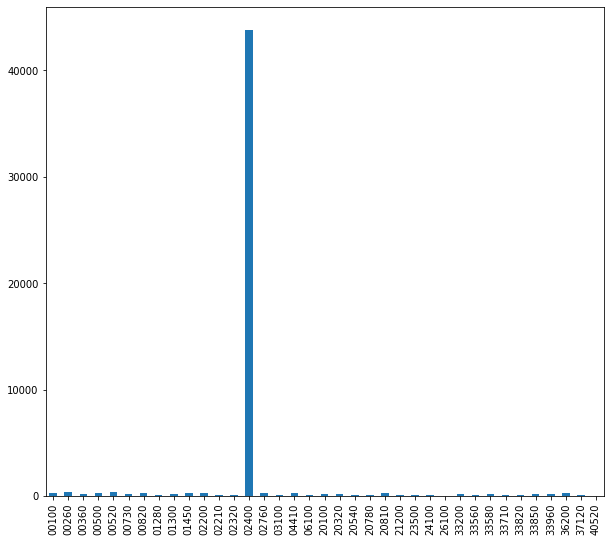

In [19]:
errs["rmse"].drop(index="02400").plot.bar()

In [53]:
pred

2021-07-01    6203.062131
2021-10-01    5974.472988
2022-01-01    5852.191521
2022-04-01    6029.809914
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [ ]:
def sarimax_fitting(multivar_ts,params):
    for column in multivar_ts
    

At iterate   30    f=  6.63122D+00    |proj g|=  4.39056D-02

At iterate   35    f=  6.59910D+00    |proj g|=  1.38668D-02

At iterate   40    f=  6.59860D+00    |proj g|=  6.11214D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     59      1     0     0   1.535D-06   6.599D+00
  F =   6.5985994159071595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.87254D+00    |proj g|=  2.54722D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     51      1     0     0   2.417D-05   6.042D+00
  F =   6.0421051073514604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07800D+00    |proj g|=  6.28082D-02

At iterate    5    f=  6.07140D+00    |proj g|=  2.77298D-02

At iterate   10    f=  6.06830D+00    |proj g|=  5.52982D-03

At iterate   15    f=  6.05788D+00    |proj g|=  1.38454D-02

At iterate   20    f=  6.05729D+00    |proj g|=  1.40134D-03

At iterate   25    f=  6.04870D+00    |proj g|=  2.94411D-02

At iterate   30    f=  6.02968D+00    |proj g|=  1.15825D-02

At iterate   35    f=  6.02230D+00    |proj g|=  2.56362D-03

At iterate   40    f=  6.02226D+00    |proj g|=  7.37826D-04

At iterate   45    f=  6.02219D+00    |proj g|=  6.86550D-0

00260    ((0, 1, 1), (0, 1, 1, 4))
00360    ((2, 1, 1), (0, 1, 1, 4))
dtype: object

In [ ]:
all_res.sort(key=lambda tup: tup[1])
all_res[0][2]

((0, 1, 1), (1, 1, 0, 7))

((0, 1, 1), (0, 1, 1, 7))

Ljung-box p-values:
[0.66101438 0.90779203 0.95160389 0.98054875 0.95892554 0.98363067
 0.96088623]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             00100   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -280.927
Date:                           Wed, 20 Oct 2021   AIC                            567.854
Time:                                   23:45:01   BIC                            572.767
Sample:                               01-01-2010   HQIC                           569.602
                                    - 04-01-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5911      0.130     -4.556      0.000      -0.845      -0.337
ma.S.L7       -0.9987      0.118     -8.436      0.000      -1.231      -0.767
sigma2      1.083e+05    1.1e-06   9.88e+10      0.000    1.08e+05    1.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                57.33
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -1.38
Prob(H) (two-sided):                  0.34   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+26. Standard errors may be unstable.
"""

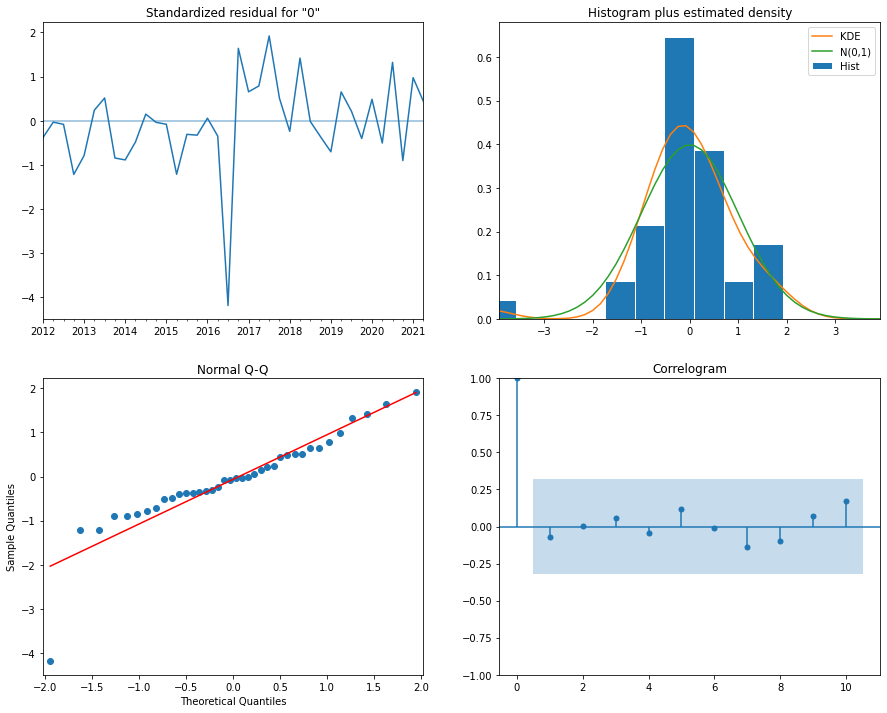

In [ ]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

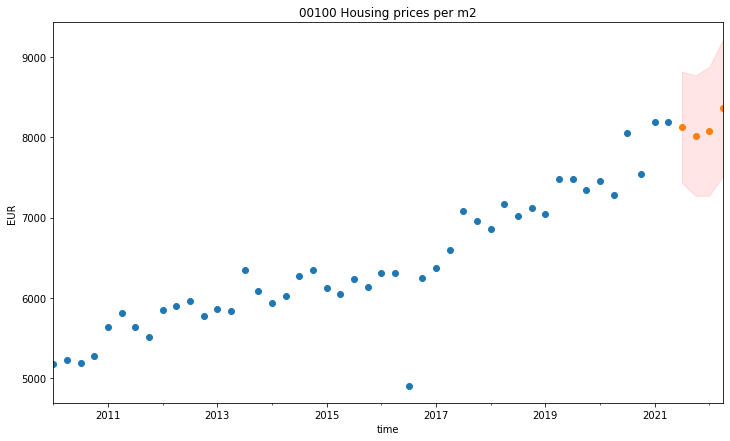

In [ ]:
pred = res.get_forecast(steps=4)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='00100 Housing prices per m2', ylabel='EUR')

df.iloc[:,0].plot(ax=ax, style = 'o')
pred.predicted_mean.plot(ax=ax, style='o')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='r', alpha=0.1)

# Predict on 20100 data

In [ ]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

# Stats packages
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("20100.csv")
df = df.iloc[:,[0,4,5]]
df.columns = ["time","flats","terraced_houses"]
df.head()

,time,flats,terraced_houses
0,2010Q1 Price per square meter (EUR/m2),2420.0,2612.0
1,2010Q2 Price per square meter (EUR/m2),2472.0,2774.0
2,2010Q3 Price per square meter (EUR/m2),2448.0,3033.0
3,2010Q4 Price per square meter (EUR/m2),2438.0,2618.0
4,2011Q1 Price per square meter (EUR/m2),2569.0,3862.0


In [ ]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df.time = df.time.apply(lambda row: quarter_to_datetime(row))

In [ ]:
df.set_index("time",inplace=True)
df_np = df.to_numpy(dtype=np.float64)

In [ ]:
mod = VARMAX(df.to_numpy(),order=(1,1),trend='t')
res = mod.fit(maxiter=200)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:           ['y1', 'y2']   No. Observations:                   46
Model:                     VARMA(1,1)   Log Likelihood                -580.807
                          + intercept   AIC                           1187.615
Date:                Wed, 20 Oct 2021   BIC                           1211.387
Time:                        23:45:05   HQIC                          1196.520
Sample:                             0                                         
                                 - 46                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             2.87, 0.00   Jarque-Bera (JB):          1.68, 15.66
Prob(Q):                        0.09, 0.97   Prob(JB):                   0.43, 0.00
Heteroskedasticity (H):         1.34, 1.06   Skew:                       0.38, 1.10
Prob(H) (two-sided):            0.58,

In [ ]:
pred = res.get_forecast(steps=4)
pred_ci = pred.conf_int()

pred.predicted_mean

array([[3831.69277355, 4288.3107533 ],
       [3881.40979854, 4342.89544177],
       [3936.71374848, 4398.75445325],
       [3988.43032784, 4455.66468092]])

ValueError: x and y must have same first dimension, but have shapes (46,) and (4, 2)

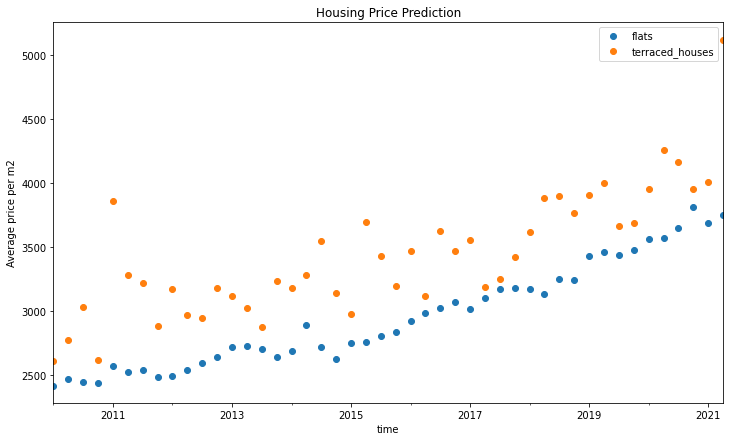

In [ ]:
pred = res.get_forecast(steps=4)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Housing Price Prediction', ylabel='Average price per m2')

df.plot(ax=ax, style = 'o')
ax.plot(df.index, pred.predicted_mean)
ax.fill_between(df.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='r', alpha=0.1)